In [1]:
# including the project directory to the notebook level
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np

In [2]:
import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    #importing modules
    from keras import backend as K

    from dataprocess import dataprocessor as dp
    from nn_source import models as mp

Using TensorFlow backend.
/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/d

In [3]:
# read the pickled file for ahu data
ahudata = dp.readfile('../data/processed/ahu1energy.pkl')

# return pickled df
ahu = ahudata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
ghidata = dp.readfile('../data/processed/ghi.pkl')

# return pickled df
ghi = ghidata.return_df(processmethods=['file2df'])

In [4]:
# selecting only required columns and rearranging them
ahu = ahu[[
    'AHU_1 outdoorAirTemp', 'WeatherDataProfile humidity',
    'AHU_1 supplyAirTemp', 'HW_BTU_METER currentKbtuDeltaReading',
    'CHW_BTU_METER currentKbtuDeltaReading'
]]

# renaming columns
ahu.columns = ['oat', 'orh', 'sat', 'hwe', 'cwe']

# Total energy is sum of heating and coling
ahu['totale'] = ahu['hwe'] + ahu['cwe']
# dropping heating and cooling energy columns
ahu = ahu.drop(columns=['hwe', 'cwe'])

In [5]:
# merging ahu and ghi data
df = dp.merge_df_columns([ahu, ghi])

# rearranging columns
df = df[['oat', 'orh', 'sat', 'Ghi', 'totale']]

In [6]:
df.head()

,oat,orh,sat,Ghi,totale
2018-07-12 13:55:00,89.554909,76.0,75.443275,872.0,35.590466
2018-07-12 14:00:00,89.863190,76.0,75.443275,866.0,33.027813
2018-07-12 14:05:00,89.863190,76.0,75.443275,859.0,31.769627
2018-07-12 14:10:00,90.484146,69.0,75.443275,848.0,34.195641
2018-07-12 14:15:00,90.826981,69.0,75.443275,836.0,31.082222


In [7]:
df['HourSine'] = np.sin(2*np.pi*df.index.hour/24.0)
df['HourCos'] = np.cos(2*np.pi*df.index.hour/24.0)
df['WeekSine'] = np.sin(2*np.pi*df.index.week/52.0)
df['WeekCos'] = np.cos(2*np.pi*df.index.week/52.0)
df['DayofWeekSine'] = np.sin(2*np.pi*df.index.dayofweek/7.0)
df['DayofWeekCos'] = np.cos(2*np.pi*df.index.dayofweek/7.0)

In [8]:
df = df[[
    'oat', 'orh', 'sat', 'Ghi', 'HourSine', 'HourCos', 'WeekSine', 'WeekCos',
    'DayofWeekSine', 'DayofWeekCos', 'totale'
]]

In [9]:
df.head()

,oat,orh,sat,Ghi,HourSine,HourCos,WeekSine,WeekCos,DayofWeekSine,DayofWeekCos,totale
2018-07-12 13:55:00,89.554909,76.0,75.443275,872.0,-0.258819,-0.965926,-0.239316,-0.970942,0.433884,-0.900969,35.590466
2018-07-12 14:00:00,89.863190,76.0,75.443275,866.0,-0.500000,-0.866025,-0.239316,-0.970942,0.433884,-0.900969,33.027813
2018-07-12 14:05:00,89.863190,76.0,75.443275,859.0,-0.500000,-0.866025,-0.239316,-0.970942,0.433884,-0.900969,31.769627
2018-07-12 14:10:00,90.484146,69.0,75.443275,848.0,-0.500000,-0.866025,-0.239316,-0.970942,0.433884,-0.900969,34.195641
2018-07-12 14:15:00,90.826981,69.0,75.443275,836.0,-0.500000,-0.866025,-0.239316,-0.970942,0.433884,-0.900969,31.082222


In [10]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist(df, subsequence=True, period=1, days=7, hours=0)

In [11]:
X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
    dflist[1],
    predictorcols=['oat', 'orh', 'sat', 'Ghi'],
    outputcols=['totale'],
    scaling=True,
    reshaping=True,
    lag=-1)

In [12]:
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(1511, 1, 4)
(504, 1, 4)
(1511, 1, 1)
(504, 1, 1)


In [13]:
!rm -rf ../results/lstmtrain2

In [14]:
# create the results directory
try:
    os.mkdir('../results/lstmtrain/')
except FileExistsError:
    files = os.listdir('../results/lstmtrain/')
    for f in files:
        os.remove('../results/lstmtrain/' + f)
        
os.mkdir('../results/lstmtrain/loginfo')

In [17]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [18]:
#Instantiate learner model
model = mp.lstm_model('../results/lstmtrain/',
                      inputdim=X_train.shape[-1],
                      outputdim=1,
                      period=1)

# Desing model architecture
model.design_model(lstmhiddenlayers=[16] * 1,
                   densehiddenlayers=[32] * 5,
                   dropoutlist=[[], []],
                   batchnormalizelist=[[], []])

In [19]:
model.show_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 1, 4)              0         
_________________________________________________________________
reshape_layer (Reshape)      (None, 4)                 0         
_________________________________________________________________
input_repeater (RepeatVector (None, 1, 4)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 32)             544       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 32)             1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1, 32)             1056      
__________

In [20]:
# creating early sstopping, model checkpointing and learning reate changing callbacks
model.model_callbacks()

In [21]:
model.train_model(X_train, y_train, X_test, y_test, epochs = 100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1511 samples, validate on 504 samples



Epoch 1/100
 - 3s - loss: 1.1429 - val_loss: 0.7999
Epoch 2/100
 - 0s - loss: 0.6170 - val_loss: 0.4419
Epoch 3/100
 - 0s - loss: 0.3353 - val_loss: 0.2323
Epoch 4/100
 - 1s - loss: 0.1777 - val_loss: 0.1208
Epoch 5/100
 - 0s - loss: 0.0948 - val_loss: 0.0635
Epoch 6/100
 - 1s - loss: 0.0537 - val_loss: 0.0371
Epoch 7/100
 - 0s - loss: 0.0345 - val_loss: 0.0250
Epoch 8/100
 - 1s - loss: 0.0252 - val_loss: 0.0193
Epoch 9/100
 - 1s - loss: 0.0208 - val_loss: 0.0170
Epoch 10/100
 - 0s - loss: 0.0194 - val_loss: 0.0169
Epoch 11/100
 - 0s - loss: 0.0191 - val_loss: 0.0169
Epoch 12/100
 - 0s - loss: 0.0190 - val_loss: 0.0168
Epoch 13/100
 - 0s - loss: 0.0152 - val_loss: 0.0134
Epoch 14/100
 - 0s - loss: 0.0135 - val_loss: 0.0126
Epoch 15/100
 - 1s - loss: 0.0130 - val_loss: 0.0124
Epoch 16/100
 - 0s - loss: 0.0128 - val_loss: 0.0124
Epoch 17/100
 - 0

In [22]:
preds_train, preds_test = model.evaluate_model(X_train,
                                                         y_train,
                                                         X_test,
                                                         y_test,
                                                         y_scaler,
                                                         saveplot=True)

Finished 'dataframeplot' in 0.6073 secs


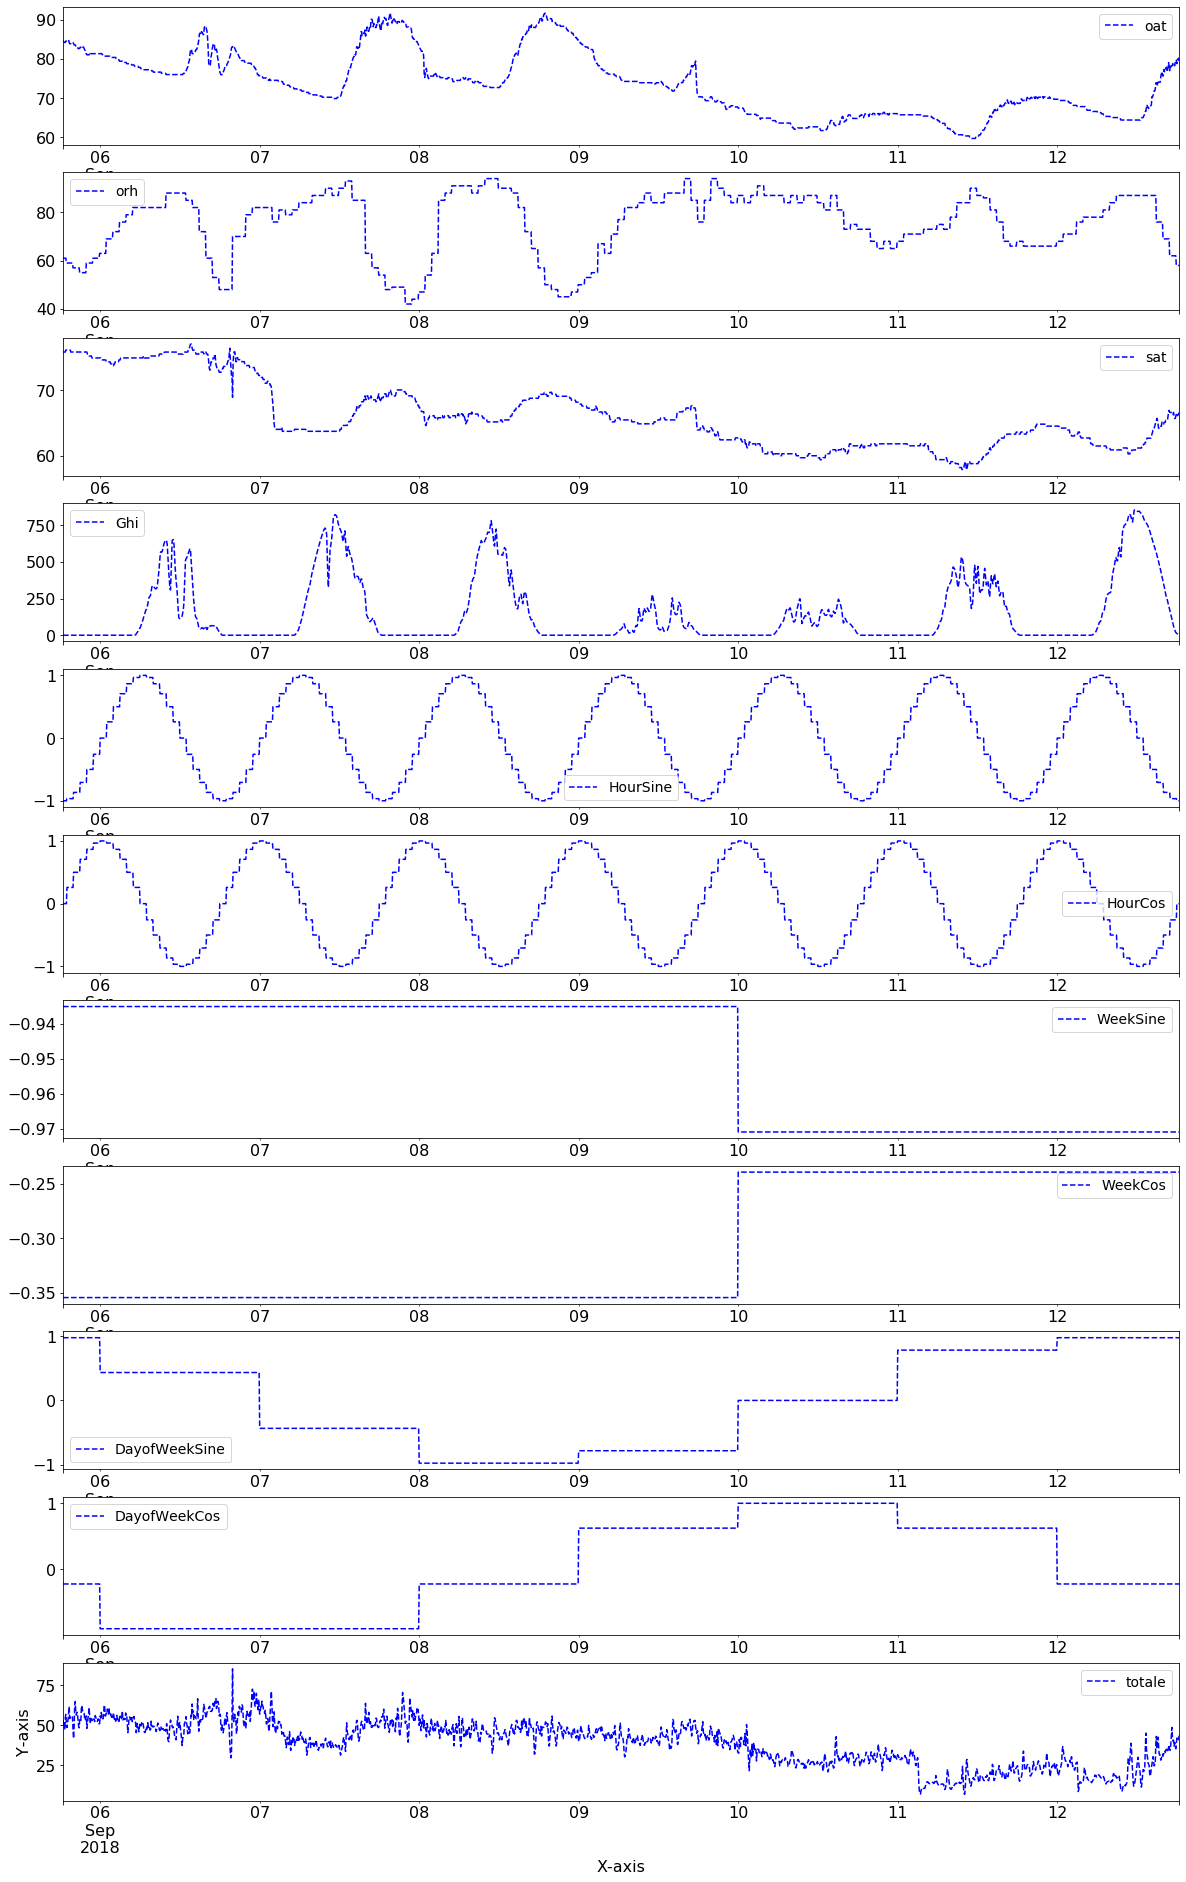

In [23]:
dp.dataframeplot(dflist[2], lazy=False, style='-', legend=True)